In [1]:
import pandas as pd
import seaborn as sns
sns.set_theme(style="whitegrid")


data = pd.read_csv('plots/data_sac_lunar_hitl_1p_sensor01.csv')

# Make interventions binary (this is a result of the environment's output)
data['Was Intervention'] = data['Was Intervention'].apply(lambda x: False if x < 0 else True)
# Once the lander is at a certain vertical position, the episode should be over, so we don't want to consider those data points
data = data[(data['Pos Vertical'] >= 0.01) | (data['Pos Vertical'] <= -0.01)]

In [4]:
violin_data = pd.melt(data, id_vars = ['Was Intervention', 'Episode Number'], var_name = 'State', value_name = 'Value')
violin_data = violin_data[~violin_data['State'].isin(['Leg 1 Contact', 'Leg 2 Contact', 'Main Engine Action', 'Left-Right Action'])]

for state in ['Pos Horizontal', 'Speed Horizontal',  'Angle', 'Angular Speed']:
    temp = violin_data[(violin_data['State'] == state) & (violin_data['Value'] <= 0)]
    violin_data.loc[temp.index, 'State'] = state + ' <= 0'
    temp = violin_data[(violin_data['State'] == state) & (violin_data['Value'] > 0)]
    violin_data.loc[temp.index, 'State'] = state + ' > 0'


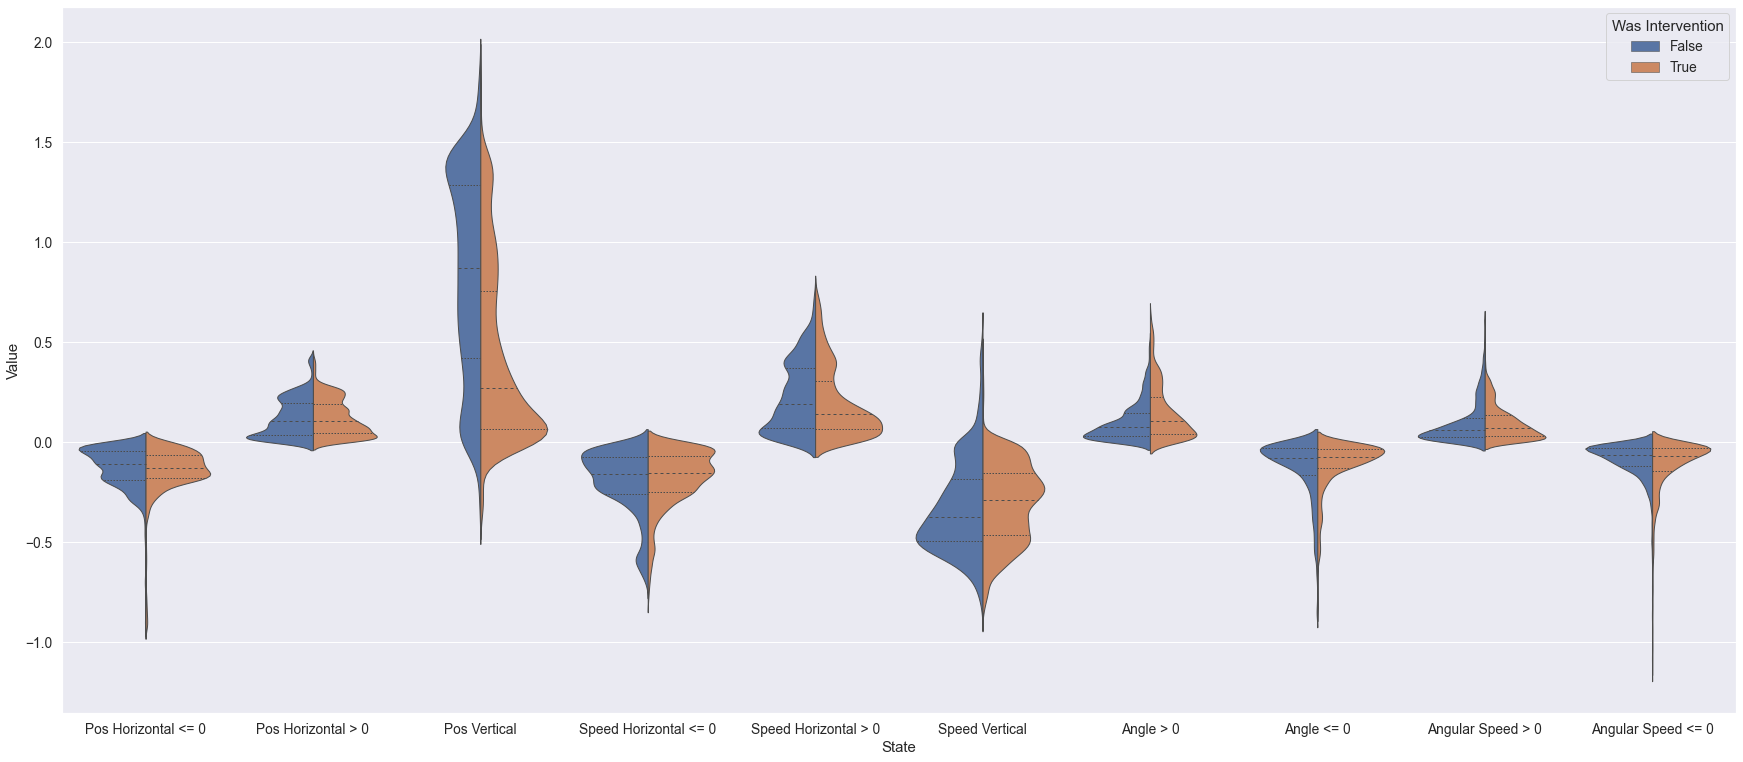

In [8]:
sns.set(rc={'figure.figsize':(30, 13)}, font_scale = 1.25)
plot = sns.violinplot(data=violin_data, x="State", y="Value", hue="Was Intervention", split=True, inner="quart", linewidth=1)
